In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

In [5]:
# Import dataset
characters_df = pd.read_csv("./dataset/Characters.csv", sep=";")
movie1_df = pd.read_csv("./dataset/Harry Potter 1.csv", sep=";")
movie2_df = pd.read_csv("./dataset/Harry Potter 2.csv", sep=";")
movie3_df = pd.read_csv("./dataset/Harry Potter 3.csv", sep=";")
potions_df = pd.read_csv("./dataset/Potions.csv", sep=";")
other_characters_df = pd.read_csv("./dataset/shortversioncharacters.csv", sep=",")
spells_df = pd.read_csv("./dataset/Spells.csv", sep=";")

In [6]:
# Analyze characters
class Character():
    def __init__(self, df):
        self.data = df
        f = open("./resources/character_mapping.json", "r")
        self.character_mapping = json.load(f)
        f.close()
        
    def map(self, character_name):
        # Map similar character to a group
        if character_name in self.character_mapping and self.character_mapping[character_name] is not None:
            return self.character_mapping[character_name].title()
        else:
            return character_name.title()

In [7]:
# Movie
movie1_df['Movie'] = 'Harry Potter and the Sorcerers Stone'
movie2_df['Movie'] = 'Harry Potter and the Chamber of Secrets'
movie3_df['Movie'] = 'Harry Potter and the Prisoner of Azkaban'

movies_list = [movie1_df, movie2_df, movie3_df]

class Movie():
    def __init__(self, df: list):
        self.movie_list = df
        self.movies_df = self.combine_movies()

    def combine_movies(self):
        # Combine movies
        for i in self.movie_list:
            i.columns = map(str.title, i.columns)
        
        return pd.concat([movie1_df, movie2_df, movie3_df], ignore_index=False)
        
    def preprocess(self):
        # Strip the spaces in character to remove identifying the same character twice
        self.movies_df["Character"] = self.movies_df.apply(lambda row: row["Character"].strip().title(), axis=1)


In [8]:
# Preprocess
def preprocessing():
    c = Character(characters_df)
    
    m = Movie(movies_list)
    m.preprocess()
    
    for i, j in m.movies_df.iterrows():
        j["Character"] = c.map(j["Character"])

    return c,m

c, m = preprocessing()

In [9]:
grouped = m.movies_df.groupby("Character").count().reset_index()
grouped.sort_values('Sentence', ascending=False)

,Character,Sentence,Movie
41,Harry,1028,1028
78,Ron,536,536
44,Hermione,485,485
40,Hagrid,394,394
21,Dumbledore,239,239
...,...,...,...
86,Slytherins,1,1
13,Cornish Pixies,1,1
69,Parvati,1,1
70,Penelope Clearwater,1,1


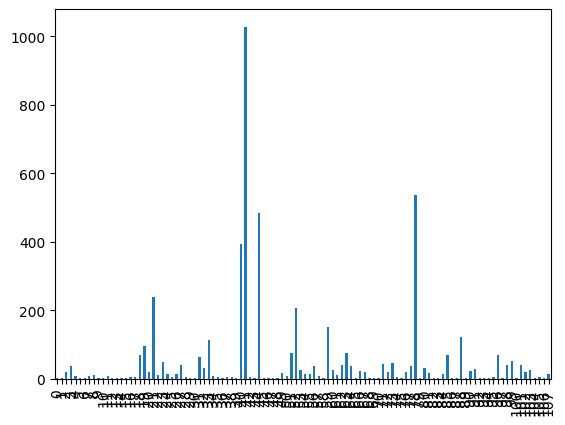

In [10]:
# create histograms for length of total script
def plotLengethOfTotalScript(df):
    # grouped.plot(kind='bar')
    pd.Series(grouped["Sentence"]).plot(kind='bar')

plotLengethOfTotalScript(m.movies_df)

In [11]:
# Combine sentences for each character
combined_sentences = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

In [12]:
#7 Construct a global vocabulary by integrating the vocabulary of each character.
import pandas as pd
import nltk
nltk.download('punkt')  # Download the NLTK tokenizer data

# Create a DataFrame from the split data
df = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

# Tokenize and preprocess the script text for each character
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    return [token for token in tokens if token.isalnum()]  # Keeps only alphanumeric tokens

# Create a dictionary to store the vocabularies for each character
character_vocabs = {}

# Create a global vocabulary set
global_vocab = set()

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    character = row['Character']
    script = row['Sentence']
    
    # Tokenize and preprocess the script text
    tokens = preprocess_text(script)
    
    # Create a vocabulary set for the current character
    character_vocab = set(tokens)
    
    # Merge the character's vocabulary into the global vocabulary
    global_vocab.update(character_vocab)
    
    # Store the character's vocabulary in the dictionary
    character_vocabs[character] = character_vocab

# Print the global vocabulary
print("Global Vocabulary:")
print(global_vocab)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Global Vocabulary:
{'parasite', 'brutus', 'lot', 'eh', 'grief', 'season', 'impressed', 'quiet', 'burma', 'errol', 'forth', 'anti', 'ooo', 'different', 'boys', 'hopefully', 'the', 'dozen', 'exposure', 'choose', 'conjured', 'followers', 'friendship', 'pomfrey', 'firm', 'cousin', 'dodgy', 'murder', 'extended', 'cat', 'longbottom', 'grate', 'model', 'families', 'defender', 'course', 'were', 'awaits', 'floor', 'back', 'destroyed', 'vast', 'hermione', 'mudbloods', 'chessboard', 'affect', 'haunted', 'witty', 'close', 'crash', 'enemies', 'particularly', 'smiling', 'hurry', 'seamus', 'conjures', 'success', 'thief', 'barely', 'trouble', 'forbidden', 'anybody', 'reunited', 'receive', 'dungeon', 'flew', 'nicolas', 'keep', 'department', 'team', 'normally', 'honor', 'greater', 'common', 'coward', 'rich', 'dare', 'spoke', 'called', 'letters', 'darling', 'sprout', 'hall', 'dispatch', 'badly', 'petunia', 'clean', 'remus', 'volunteer', 'fascinating', 'host', 'pettigrew', 'lived', 'map', 'artifacts', 'ca

In [34]:
#7 Write a script using tf-idf vectorizer of Gensim to provide a vector representation of each corpus 
import gensim
from gensim import corpora

# Group script text by character
character_scripts = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

# Tokenize and preprocess the script for each character
character_scripts['Preprocessed_Script'] = character_scripts['Sentence'].apply(preprocess_text)

# Create a dictionary for the scripts
dictionary = corpora.Dictionary(character_scripts['Preprocessed_Script'])

# Create a corpus for the scripts
corpus = [dictionary.doc2bow(text) for text in character_scripts['Preprocessed_Script']]

# Create a TF-IDF model from the corpus
tfidf = gensim.models.TfidfModel(corpus)

# Calculate TF-IDF vectors for each character's script
tfidf_vectors = [tfidf[doc] for doc in corpus]

# Print the TF-IDF vectors for each character
for idx, character in enumerate(character_scripts['Character']):
    print(f"TF-IDF vector for {character}:")
    print(tfidf_vectors[idx])




TF-IDF vector for All:
[(0, 0.7612029502212122), (1, 0.6485137381540368)]
TF-IDF vector for All 3:
[(2, 0.30466218134016293), (3, 0.3132829511181129), (4, 0.7258686946588154), (5, 0.48199495410107907), (6, 0.09670877841777692), (7, 0.20119061188864393)]
TF-IDF vector for Aragog:
[(6, 0.09773421377695736), (7, 0.058092543684674036), (8, 0.08326701757566829), (9, 0.13692244013053181), (10, 0.13692244013053181), (11, 0.031326149098346134), (12, 0.04652918656065327), (13, 0.10479504599634024), (14, 0.022520747874035067), (15, 0.06191405019042735), (16, 0.09638218240257468), (17, 0.0597468652295211), (18, 0.08985665843427272), (19, 0.13692244013053181), (20, 0.08985665843427272), (21, 0.06265229819669227), (22, 0.09638218240257468), (23, 0.036500242501542685), (24, 0.13359863084926366), (25, 0.0726676518621487), (26, 0.13692244013053181), (27, 0.10479504599634024), (28, 0.13692244013053181), (29, 0.11665231126655325), (30, 0.11665231126655325), (31, 0.13692244013053181), (32, 0.051203740331

In [35]:
#7 use the cosine similarity to calculate the similarity between two characters. Write down the new similarity matrix.
from gensim.models import TfidfModel
from sklearn.metrics.pairwise import cosine_similarity

# Convert TF-IDF vectors to a format compatible with softcossim
tfidf_matrix = gensim.matutils.corpus2csc(tfidf_vectors)

# Calculate cosine similarity between character TF-IDF vectors
cosine_similarity_matrix = cosine_similarity(tfidf_matrix.T, tfidf_matrix.T)

# Create a DataFrame to represent the similarity matrix
character_names = character_scripts['Character']
similarity_df = pd.DataFrame(cosine_similarity_matrix, columns=character_names, index=character_names)

# Print the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(similarity_df)


Cosine Similarity Matrix:
Character     All     All 3    Aragog  Aunt Marge  Aunt Petunia  \
Character                                                         
All           1.0  0.000000  0.000000    0.000000      0.000000   
All 3         0.0  1.000000  0.021139    0.027811      0.008933   
Aragog        0.0  0.021139  1.000000    0.079804      0.066767   
Aunt Marge    0.0  0.027811  0.079804    1.000000      0.121821   
Aunt Petunia  0.0  0.008933  0.066767    0.121821      1.000000   
...           ...       ...       ...         ...           ...   
Voldemort     0.0  0.097665  0.118642    0.189697      0.047272   
Whispers      0.0  0.000000  0.000000    0.000000      0.106049   
Witch         0.0  0.017032  0.037549    0.091908      0.025585   
Woman         0.0  0.006709  0.006780    0.017086      0.006407   
Wood          0.0  0.037610  0.053962    0.083058      0.028042   

Character     Aunt Petunia & Dudley  Barkeep Tom       Bem       Boy  \
Character                     

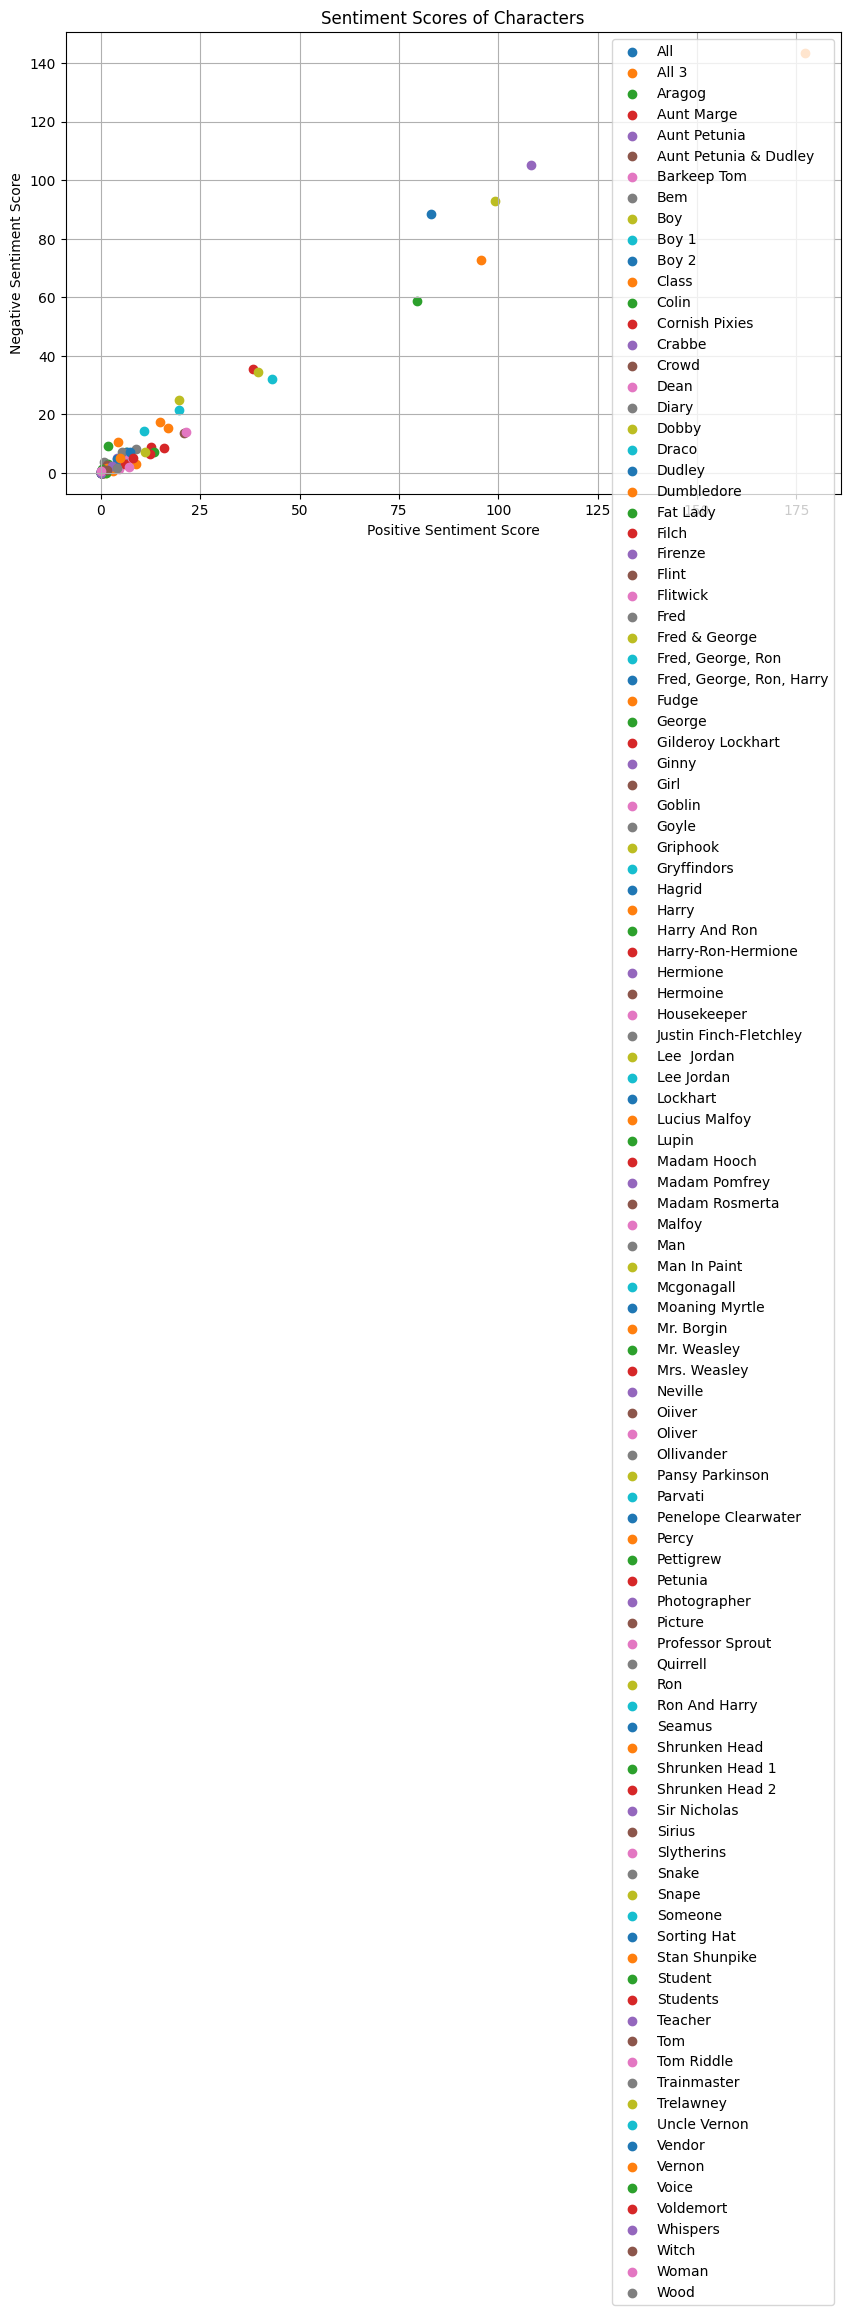

In [36]:
#8
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt

# Group script text by character

character_scripts = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()
# Tokenize and preprocess the script for each character
character_scripts['Preprocessed_Script'] = character_scripts['Sentence'].apply(preprocess_text)

# Function to calculate sentiment score for a token
def get_sentiment_score(token):
    synsets = list(swn.senti_synsets(token))
    if synsets:
        # Take the first synset
        synset = synsets[0]
        return synset.pos_score(), synset.neg_score()
    else:
        return 0, 0

# Calculate sentiment scores for each character's script
character_sentiment_scores = []

for script in character_scripts['Preprocessed_Script']:
    positive_scores = []
    negative_scores = []
    
    for token in script:
        pos_score, neg_score = get_sentiment_score(token)
        positive_scores.append(pos_score)
        negative_scores.append(neg_score)
    
    # Aggregate sentiment scores for the script
    total_positive_score = sum(positive_scores)
    total_negative_score = sum(negative_scores)
    
    character_sentiment_scores.append((total_positive_score, total_negative_score))

# Create a scatter plot of sentiment scores
plt.figure(figsize=(10, 6))

for i, character in enumerate(character_scripts['Character']):
    x, y = character_sentiment_scores[i]
    plt.scatter(x, y, label=character, marker='o')

plt.xlabel('Positive Sentiment Score')
plt.ylabel('Negative Sentiment Score')
plt.title('Sentiment Scores of Characters')
plt.legend()
plt.grid(True)
plt.show()

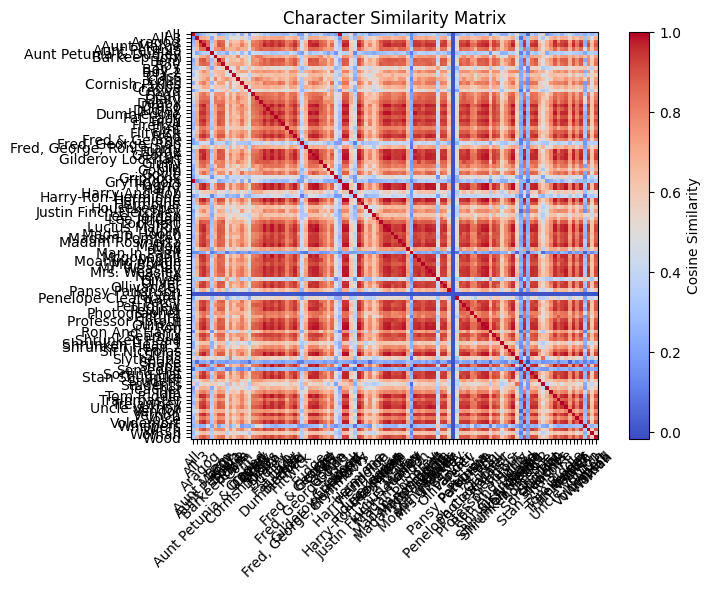

In [37]:
import gensim
import pandas as pd
import nltk
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import gensim.downloader as api

# Download and load the Word2Vec model
model = api.load("word2vec-google-news-300")

# Group script text by character
character_scripts = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

# Tokenize and preprocess the script for each character
character_scripts['Preprocessed_Script'] = character_scripts['Sentence'].apply(preprocess_text)

# Function to calculate the average Word2Vec embedding for a script
def calculate_average_embedding(tokens, model):
    embeddings = [model[token] for token in tokens if token in model.key_to_index]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Calculate average Word2Vec embeddings for each character's script
character_embeddings = []

for script_tokens in character_scripts['Preprocessed_Script']:
    character_embedding = calculate_average_embedding(script_tokens, model)
    character_embeddings.append(character_embedding)

# Calculate cosine similarity between character embeddings
similarity_matrix = cosine_similarity(character_embeddings)

# Create a DataFrame to represent the similarity matrix
character_names = character_scripts['Character']
similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)

# Visualize the similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.xticks(np.arange(len(character_names)), character_names, rotation=45)
plt.yticks(np.arange(len(character_names)), character_names)
plt.title('Character Similarity Matrix')
plt.tight_layout()
plt.show()